# __Data-Driven Discovery of Stochastic Differential Equations__

__Method 3: Bayesian Inference__

This methos uses Bayesian Inference for Stochastic Differential Equation (BISDE) for computing the coefficients of drift and diffusion.  <br>
In the next line, it will be explained how to run the notebook and some examples for showing the strength of this method.

# _SECTION I: BASIC FUNCTIONS_

This section focus on creating the backbone of the proyect. In each function there's a short description. This part contains: 
1. Drifts and diffusion for each example.
2. Generator of trayectories up to 3D (can be used for higher dimensions).
3. Library generator for infering the terms of the drift and diffusion.
4. BISDE algorithm.

In [163]:
#Load necessary packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Forces and potentials

In [165]:
#### Equations used for the 1D Double well potential ###
def potential_double_well(x, delta_u,L):
    """"1D Double well potential"""
    return delta_u*(-1 +(x/L)**2)**2

def force_double_well(x,delta_u, L):
    """"1D Force | Double well potential"""
    return 4*delta_u*x/(L**2) - (4*delta_u*x**3)/L**4

def drift_dw(C1,C2,x):
    return C1*x + C2*x**3

def diff_dw(x, D):
    return D

### Equations used for the 1D Harmonic Oscillator ###
def harmonic_potential(x,k):
    """1D Harmoic Oscillator Potential """
    return (k*x**2)/2

def harmonic_force(x,k):
    """1D Harmonic Oscillator Force"""
    return -k*x

def drift_ho(k, gamma, x):
    return (-k/gamma)*x

def diff_ho(x, D):
    return D




#### Equations used for the 2D Double well potential ###
def drift2ddw_x(c0,c1,x,y):
    """"2D Force | Double well potential"""
    return c0*x**3 + c1*x

def drift2ddw_y(c3, x,y):
    """"2D Force | Double well potential"""
    return c3*y

def diff2ddw_x(x,y):
    """"2D Difussion | x axis"""
    return 2 

def diff2ddw_y(x,y):
    """"2D Difussion | y axis"""
    return 2 

def pot_3(x,y):
    """2D Double well potential"""
    return (x**2 - 1)**2 +y**2

#### Equations used for the 2D Harmonic Oscillator ###
def drift2_x(x,y, k0, k1):
    """"2D Force | x axis"""
    return -k0*x + k1*y

def drift2_y(x,y,k0, k1):
    """"2D Force | y axis"""
    return -k0*y - k1*x

def diff2_x(x,y):
    """"2D Difussion | x axis"""
    return 2

def diff2_y(x,y):
    """"2D Difussion | y axis"""
    return 2

#### Equations used for the Lorentz Attractor ###
def drift_x_3d(x, y, z, sigma):
    """Lorents attractor x axis"""
    return -sigma*x + sigma*y

def drift_y_3d(x, y, z, rho):
    """Lorents attractor y axis"""
    return rho*x -x*z - y

def drift_z_3d(x, y, z, beta):
    """Lorents attractor z axis""" 
    return x*y -beta*z

def diff_x_3d(x, y, z):
    return 0.1

def diff_y_3d(x, y, z):
    return 0.1

def diff_z_3d(x, y, z):
    return 0.1

#### Equations used for theFour-Wing ###
def drift_x_3d_f(x, y, z, a):
    """Four-wing attractor x axis"""
    return a*x +y*z

def drift_y_3d_f(x, y, z, b, c):
    """Four-wing attractor y axis"""
    return b*x +c*y -x*z

def drift_z_3d_f(x, y, z):
    """Four-wingattractor z axis""" 
    return -z-x*y

### Equations used for HALVORSEN ###
def drift_x_3d_h(x, y, z, q):
    """Halvorsen  attractor x axis"""
    return -q*x -4*y -4*z -y**2

def drift_y_3d_h(x, y, z,q ):
    """Halvorsen  attractor y axis"""
    return -q*y -4*z -4*x -z**2

def drift_z_3d_h(x, y, z, q):
    """Halvorsen  attractor z axis""" 
    return -q*z -4*x -4*y -x**2


# Trayectories

In [168]:

###Generate trayectories###
def generate_trayectories(
        pos_init, time_step,    
        iterations, sets, example,
        natural_units = True,      
        C1 = 0.64, C2 = -0.0256, D=2,
        k = 3, m = 5, 
        c0 = -4, c1 = 4, c2 =-2,
        sigma = 10, rho = 28, beta = 8/3,
        a = 0.2, b= 0.1, c=-0.4, q = 1.89 ):
    """
    GENERATE 1D/2D/3D TRAYECTORIES USING THE EULER-MARUYAMA DISCRETIZATION FOR THE LANGEVIN EQUATION

    Global parameters:
        pos_init <- initial position for running the iterations 
        time_ste <- dt discretization for computing trayectory
        iterations <- number of points generated for the trayectory
        sets <- number of trayectories generated (default value is 1)
        example <- define what kind of experiment you would like to recreate
        natural_units <- set physical quantities (temperature, friction coefficient, boltzman constant) equal to one

    Specific patameters:
        1D Double well potential: C1 <- first coefficient drift(set default value to 4)
                                  C2 <- second coefficient drift (Set default value to 5)
        1D Harminc Oscillator: k <- stiffness coefficient (set default value to 3)
        2D Harmonic Oscillator: k (same as 1D)
                                m <- (set default value to 5)
        3D Lorentz attractor: sigma <- set default value to 10
                              rho <- set default value to 28
                              beta <- set default value to 8/3
        3D FOUR WING a <- set default value to 0.2
                     b <- set default value to 0.1
                     c <- set default value to -0.4
        3D HALVORSEN: q <- set default value to 1.89

        """
    #generate array for storing position and time
    positions = np.zeros((len(pos_init), iterations))
    time = np.zeros(iterations)

    #generate gaussian noise with mean 0 and variance 1
    gaussian_noise = np.random.normal(size = (len(pos_init), iterations))*np.sqrt(time_step)


    #store initial position
    for i in range(0,len(pos_init)):
        positions[i,0] = pos_init[i]
        
  
    if natural_units == True:
        T = kb = gamma = 1

    #generate trayectories for 1D examples
    if example == "1D HARMONIC OSCILLATOR" or example == "1D DOUBLE WELL POTENTIAL":
        for i in range (1,iterations,1):
            if example == "1D DOUBLE WELL POTENTIAL":
                update =  drift_dw(C1,C2,positions[0,i-1])*time_step + np.sqrt(diff_dw(positions[0,i-1], D)*kb*T/gamma)*gaussian_noise[0,i]
            if example == "1D HARMONIC OSCILLATOR":
                update =  drift_ho(k, gamma, positions[0,i-1])*time_step + np.sqrt(diff_ho(positions[0, i-1],D)*kb*T/gamma)*gaussian_noise[0,i]
            positions[0,i] = positions[0,i-1] + update
            time[i] = time[i-1] + time_step

        return positions[0], time

    #generate trayectories for 2D examples
    if example == "2D HARMONIC OSCILLATOR" or example == "2D DOUBLE WELL POTENTIAL":
        for i in range(1, iterations):
            if example == "2D HARMONIC OSCILLATOR":
                update_x = drift2_x(positions[0, i-1], positions[1, i-1], k, m)*time_step + np.sqrt(2*kb*T/gamma)*gaussian_noise[0,i]
                update_y = drift2_y(positions[0, i-1], positions[1, i-1], k, m)*time_step + np.sqrt(2*kb*T/gamma)*gaussian_noise[1,i]
            if example == "2D DOUBLE WELL POTENTIAL":
                update_x = drift2ddw_x(c0, c1, positions[0, i-1], positions[1, i-1])*time_step + np.sqrt(diff2ddw_x(positions[0, i-1], positions[1, i-1])*kb*T/gamma)*gaussian_noise[0,i]
                update_y = drift2ddw_y(c2, positions[0, i-1], positions[1, i-1])*time_step + np.sqrt(diff2ddw_y(positions[0, i-1], positions[1, i-1])*kb*T/gamma)*gaussian_noise[1,i]

            positions[0,i] = positions[0,i-1] + update_x
            positions[1,i] = positions[1,i-1] + update_y
            time[i] = time[i-1] + time_step
    
        return positions[0], positions[1], time

    #generate trayectories for 3D examples
    if example == "3D LORENTZ ATTRACTOR" or example == "3D FOUR-WING" or example == "3D HALVORSEN":
        for i in range(1, iterations):
            if example == "3D LORENTZ ATTRACTOR":
                update_x = drift_x_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1], sigma)*time_step + np.sqrt(diff_x_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[0,i]
                update_y = drift_y_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1], rho)*time_step + np.sqrt(diff_y_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[1,i]
                update_z = drift_z_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1], beta)*time_step + np.sqrt(diff_z_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[2,i]

            if example == "3D FOUR-WING":
                update_x = drift_x_3d_f(positions[0, i-1], positions[1, i-1], positions[2, i-1], a)*time_step + np.sqrt(diff_x_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[0,i]
                update_y = drift_y_3d_f(positions[0, i-1], positions[1, i-1], positions[2, i-1], b, c)*time_step + np.sqrt(diff_y_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[1,i]
                update_z = drift_z_3d_f(positions[0, i-1], positions[1, i-1], positions[2, i-1])*time_step + np.sqrt(diff_z_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[2,i]

            if example == "3D HALVORSEN":
                update_x = drift_x_3d_h(positions[0, i-1], positions[1, i-1], positions[2, i-1], q)*time_step + np.sqrt(diff_x_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[0,i]
                update_y = drift_y_3d_h(positions[0, i-1], positions[1, i-1], positions[2, i-1], q)*time_step + np.sqrt(diff_y_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[1,i]
                update_z = drift_z_3d_h(positions[0, i-1], positions[1, i-1], positions[2, i-1], q)*time_step + np.sqrt(diff_z_3d(positions[0, i-1], positions[1, i-1], positions[2, i-1]))*gaussian_noise[2,i]


            positions[0, i] = positions[0, i-1] + update_x
            positions[1, i] = positions[1, i-1] + update_y
            positions[2, i] = positions[2, i-1] + update_z
            time[i] = time[i-1] + time_step

        return positions[0], positions[1], positions[2], time

# Libraries

In [12]:
#Generate libraries for obtaining drift and diffusion
def library(trayectories, length, dimension):
    """LIBRARY 

        Based on a "prior" knowledge, construct a library for computing the drift and diffusion. The most basic is
        made of polynomials up to 20th order. More complex library terms can be also taken into account but for this
        proyect we just use polynomials.

        Input parameters:       results <- list with the trayectories computed using euler-maruyana method
                                length  <- maximum order of polynomial generated (i.e. order = 3 -> [1, x, x**2, x**3])
                                dimension <- define if there's more thant 1 dimension (i.e. D = 2 -> 1, x, y, x**2, y**2, xy, xy**2, yx**2, x**2y**2)
    """
    #generate array with ones
    index = 0
    library = np.ones((length**dimension ,len(trayectories[0])-1))

    #create library for 1D examples [1, x, x**2, x**3]
    if dimension == 1:
        for i in range (0, length):
            library[i] = trayectories[0][:-1]**i
     
    #create library for 2D examples [1, y, y**2, x, xy, xy**2, x**2, x**2y, x**2y**2]   
    if dimension == 2:
        for i in range (0, length):
            for j in range(0,length):
                library[index] = (trayectories[0][:-1]**i)*(trayectories[1][:-1]**j)
                index= index + 1
    
    #create library for 3D examples [1, z, y, zy, x, xz, xy, xyz]
    if dimension == 3:
        for i in range (0, length):
            for j in range(0,length):
                for k in range(0,length):
                    library[index] = (trayectories[0][:-1]**i)*(trayectories[1][:-1]**j)*(trayectories[2][:-1]**k)
                    index= index + 1
    
    return library

#Compute expectation value for the drift
def output_vectors_dr(trayectories, dt):
    """ Parameters: trayectories <- trayectories of the example chosen
                    dt <- time step 
    """

    output = np.diff(trayectories)/dt
    return(np.asarray(output))

#Compute expectation value for the diffusion
def output_vectors_di(trayectories, dt, library, drift):
    """ Parameters: trayectories <- trayectories of the example chosen
                    dt <- time step
                    library <- library generated with polynomials
                    drift <- coefficient of the drift term previously computed
        IMPORTANT: Note that for computing the diffusion term it is necesary to compute drift first
    """
    
    output = np.diff(trayectories)
    output = np.asarray(output)
    output = output.reshape(len(output))
    output = ((output- np.dot(library,drift)*dt)**2)/dt
    return(output)

# Backbone

In [275]:
def bisde_pythonic(PHI, Y, max_iters):
    """BAYESIAN INFERENCE FOR STOCHASTIC DIFFERENTIAL EQUATION
            Taken from: Data-Driven Discovery of Stochastic Differential Equations | Yasen Wang et al.
            Converted into pythonic version

        Global parameters:
            prune_gama <- threshold for eliminating values in the library
            lambda_0 <- initial value for lambda
            Learn_Lambda <- If is set, compute new lambda value for each iteration (regularization)

        Input parameters:
            PHI <- Library 
            Y <- expected values of the drift and diffusion (output vectors)
            max_iters <- number of iterations 
        """
    
    #default control parameters
    prune_gama = 1*10**-4 
    lambda_0 = 1
    Learn_Lambda = 1


    N, M = PHI.shape
    N, L = Y.shape

#generate initial values

    gamma = 0.5*np.ones(M) #generate values of gamma for each conlumn of the library (10)
    keep_list = np.arange(0,M) #create indexes for each column of the library
    m = len(keep_list) #count number of elements in keep_list
    mu = np.zeros((M, L))
    count = 0
    index=[]

    for i in range (0, max_iters):
        if min(gamma) < prune_gama:
            for j in range (0, len(gamma)):
                if gamma[j] > prune_gama:  #take indexes of elements less than 
                    index.append(j)
            gamma = gamma[index]
            PHI = PHI[:, index] #extract related lib elements
            keep_list = keep_list[index] #store indexes 
            m = len(gamma) #compute number of indexes taken
            index=[]

        if count == 1: 
            gamm = gamma
    
        mu_old = mu
        Gamma = np.diag(gamma) #create identity matrix with diagonal equal to gamma elements
        G = np.diag(np.sqrt(gamma))

    

        U, S, V = np.linalg.svd(np.dot(PHI,G), full_matrices = False)


    
        U = U.transpose()
        di = len(S)

        if di > 1:
            diag_S = S
            aa= np.diag(diag_S/(diag_S**2 + lambda_0 + 1e-16 ))

    
        else:
            diag_S = S[0]
            aa= diag_S/(diag_S**2 + lambda_0 + 1e-16 )

   

        Xi = np.dot(np.dot(np.dot(G,np.transpose(V)), aa ), U)
        mu = np.dot(Xi,Y)
    

        #update hyperparameters
        gamma_old = gamma
        mu2_bar = (abs(mu)**2)/L
        mu2_bar = mu2_bar.reshape(1, len(mu2_bar))


        multi = sum(np.multiply(np.transpose(Xi), np.dot(PHI, Gamma)))
    
        Sigma_w_diag = np.real(gamma - multi)
        gamma = Sigma_w_diag + mu2_bar
        gamma = gamma.reshape(len(gamma[0]))

        if Learn_Lambda == 1:
            den = N-m + np.sum(Sigma_w_diag/gamma_old)

            lambda_0 = (np.linalg.norm(Y-np.dot(PHI,mu), ord = "fro")**2/L)/den

        count = count +1

    mu = mu.reshape(len(mu))
    mu_final = np.zeros(M)
    mu_final[keep_list] = mu
    
    return mu_final
    

def msbl_running(positions, delta_t, tsh, iterations, library_order, dimension, compute_diff = True ):
    """BISDE RUNNING
            Take generated trayectories (1D/2D/3D) and library and infere the drift and difussion coefficients
    
    """
    lib = library(positions, library_order, dimension)                    
    lib = lib.T
    inferred_terms =[]
    n=1
    for i in range(0,len(positions)):
        #compute drift
        Edr = output_vectors_dr(positions[i], delta_t)
        Edr = Edr.reshape(len(Edr), 1) 
        solution_dr =  bisde_pythonic(lib, Edr, iterations)    
        solution_dr[abs(solution_dr) < tsh] =0
        #compute difussion
        if compute_diff == True:
            n=2
            Edi = output_vectors_di(positions[i], delta_t, lib, solution_dr)
            Edi= Edi.reshape(len(Edi),1)
            solution_di = bisde_pythonic(lib, Edi, iterations)
            solution_di[abs(solution_di) < tsh] = 0
            inferred_terms.append(solution_di)
        inferred_terms.append(solution_dr)

    
    return np.asarray(inferred_terms).reshape(n*dimension, len(lib.T))


# Others

In [15]:
def porcentage_error(real, obtained):
    return abs(((abs(real)-abs(obtained))/abs(obtained))*100)

In [306]:
def bisde_tester_random(example, points):
    number_samples = 50000
    time_step = 0.04

    if example == "1D HARMONIC OSCILLATOR":
        k_real = 3 + np.random.uniform(-2,2,points)
        k_init = [0]
        k_obtained = np.zeros(len(k_real))
        for i in range (0,len(k_real)):
            trayectory_ha, time = generate_trayectories(k_init, time_step, number_samples, 1, example, k = k_real[i])
            inferred_ha = msbl_running([trayectory_ha], time_step, 0.05, 100, 3, 1, compute_diff = False)
            k_obtained[i] = inferred_ha[0,1]
    
        return k_real, k_obtained

    if example == "1D DOUBLE WELL POTENTIAL":
        H = np.random.uniform(2,5,points)
        L0 = np.random.uniform(2,5,points)
        c1_real = 4*H/(L0**2)
        c2_real = -4*H/(L0**4)
        c1_obtained = np.zeros(len(c1_real))
        c2_obtained = np.zeros(len(c2_real))
        x_init = [0]
        for i in range (0,len(c1_real)):
            trayectory_dw, time = generate_trayectories(x_init, time_step, number_samples, 1, example, C1 = c1_real[i], C2 = c2_real[i]  )
            inferred_dw = msbl_running([trayectory_dw], time_step, 0.01, 1000, 5, 1, compute_diff = False )
            c1_obtained[i] = inferred_dw[0,1]
            c2_obtained[i] = inferred_dw[0,3]

        return c1_real, c1_obtained, c2_real, c2_obtained
    
    if example == "2D DOUBLE WELL POTENTIAL":
        xy_init = [1,1]                                      
        c0_real = -4 +np.random.uniform(-2,2,points)               #x**3                         
        c1_real =  4 +np.random.uniform(-2,2,points)               #x                                 
        c2_real = -2 +np.random.uniform(-2,2,points)
        c0_obtained = np.zeros(len(c2_real))
        c1_obtained = np.zeros(len(c1_real))
        c2_obtained = np.zeros(len(c2_real))
        for i in range (0,len(c0_real)):                                             
            trayectories2d_dwx, trayectories2d_dwy, time_values_2ddw = generate_trayectories(xy_init, time_step,number_samples, 1, "2D DOUBLE WELL POTENTIAL", c0 =c0_real[i], c1=c1_real[i], c2 =c2_real[i])
            inferred_2dw = msbl_running([trayectories2d_dwx, trayectories2d_dwy], time_step, 0.01, 1000, 4, 2, compute_diff = False )
            c0_obtained[i] = inferred_2dw[0,12]
            c1_obtained[i] = inferred_2dw[0,4]
            c2_obtained[i] = inferred_2dw[1,1]

        return  c0_real, c0_obtained, c1_real, c1_obtained, c2_real, c2_obtained
    
    if example == "2D HARMONIC OSCILLATOR":
        xy_init = [1,1]                                      
        k0_real = 3 + np.random.uniform(-2,2,points)                                 
        k1_real = 5 + np.random.uniform(-2,2,points)                                              
        k0_obtained = np.zeros(len(k0_real))
        k1_obtained = np.zeros(len(k1_real))
        for i in range (0,len(k0_real)):                                             
            trayectories2d_hax, trayectories2d_hay, time_values_2dha = generate_trayectories(xy_init, time_step,number_samples, 1, "2D HARMONIC OSCILLATOR", k = k0_real[i], m = k1_real[i])
            inferred_2dha = msbl_running([trayectories2d_hax, trayectories2d_hay], time_step, 0.05, 700, 2, 2, compute_diff = False )
            k0_obtained[i] = inferred_2dha[0,2]
            k1_obtained[i] = inferred_2dha[0,1]

        return  k0_real, k0_obtained, k1_real, k1_obtained


# _SECTION II: GENERAL EXAMPLES_

In this part, we will show several examples using the BISDE algorithm for infering drift and diffusion. The examples are the following: <br>
1) Double well potential
2) Harmonic Oscillator
3) 2D Double well potential
4) 2D Harmonic Oscillator
5) 3D Attractors

For simplicity all examples use temperature, gamma and boltzman constant equal to 1. Additionally, diffusion term is equal to 2. <br>
It works also with different difussion but we only focus on varying the drift.

# A) Double Well Potential

__1) For the first example, we will use a double well potential that can be found in [2]. Set initial parameters and compute trayectories and display.__

In [208]:
#Set initial conditions
number_samples = 80000                               #total number of iterations
time_step = 0.04                                     #time step for euler differentation
L_stable = [0]                                       #initial position
L0 =  5                                              #distance from the center to the minimum
H = 4                                                #height of the maximum
C1 = 4*H/(L0**2)                                     #First coefficient of drift
C2 = -4*H/(L0**4)                                    #Second coefficient of drift
D = 2                                                #Coefficient for the difussion

#Compute trayectories
trayectories_dw, time_values_dw = generate_trayectories(L_stable, time_step, number_samples, 1, "1D DOUBLE WELL POTENTIAL", C1 = C1, C2 = C2, D =2)

__2) Plot the potential and drift used.__ 

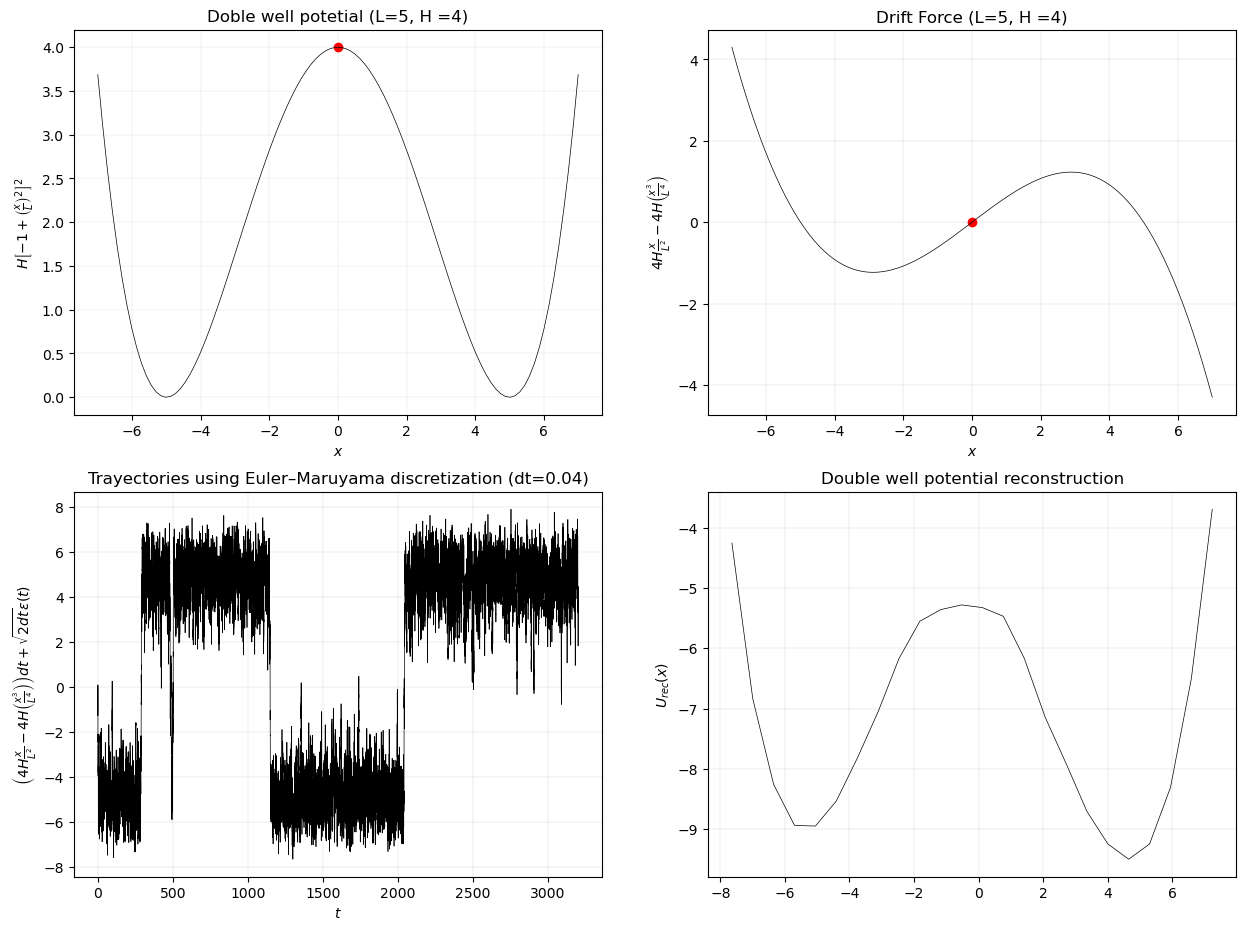

In [209]:
x_pot = np.linspace(-7,7,100)
#store histogram values
hist_values_dw = plt.hist(trayectories_dw, bins="doane")
hist_x_dw, hist_y_dw = hist_values_dw[0], hist_values_dw[1]
plt.close()

#Plottings
# 1) plot the potential used
fig, axis = plt.subplots(2,2, figsize=(15,11))
axis[0,0].plot(x_pot, potential_double_well(x_pot, H, L0), color = "k", linewidth = 0.5) #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,0].scatter(L_stable, potential_double_well(L_stable[0],H, L0) , c = "r") 
axis[0,0].set_title("Doble well potetial (L={}, H ={})".format(L0,H))
axis[0,0].set_ylabel(r"$H\left [ -1 +\left ( \frac{x}{L}\right)^{2} \right ]^{2}$")
axis[0,0].set_xlabel(r"$x$")
axis[0,0].grid(color='k', linestyle='--', linewidth=0.05)

# 2) plot the drift
axis[0,1].plot(x_pot, force_double_well(x_pot, H, L0), color = "k", linewidth = 0.5) #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,1].scatter(L_stable,force_double_well(L_stable[0],H, L0) , c = "r") 
axis[0,1].set_title("Drift Force (L={}, H ={})".format(L0,H))
axis[0,1].set_ylabel(r"$4H\frac{x}{L^{2}} - 4H\left ( \frac{x^{3}}{L^{4}} \right )$")
axis[0,1].set_xlabel(r"$x$")
axis[0,1].grid(color='k', linestyle='-', linewidth=0.05)

# 3) plot the generated trayectories
axis[1,0].plot(time_values_dw, trayectories_dw, color ="k", linewidth = 0.5)
axis[1,0].set_title("Trayectories using Euler–Maruyama discretization (dt={})".format(time_step))
axis[1,0].set_ylabel(r"$\left (4H\frac{x}{L^{2}} - 4H\left ( \frac{x^{3}}{L^{4}} \right )  \right )dt + \sqrt{2dt}\varepsilon (t)$")
axis[1,0].set_xlabel(r"$t$")
axis[1,0].grid(color='k', linestyle='-', linewidth=0.05)

#4) plot the reconstructed potential using the trayectories computed 
axis[1,1].plot(hist_y_dw[:-1],-np.log(hist_x_dw), color = "k", linewidth = 0.5)
axis[1,1].set_title("Double well potential reconstruction")
axis[1,1].set_ylabel(r"$U_{rec}(x)$")
axis[1,1].grid(color='k', linestyle='-', linewidth=0.05)

__3. Generate library, and infere coefficients for drift and difussion__

In [210]:
#Compute drift and difussion coefficients
inferred_dw = msbl_running([trayectories_dw], time_step, 0.02, 1000, 10, 1)

In [212]:
print("The real coefficients for the drift are: {}*x | {}*x**3".format(C1,C2))
print("The obtained coefficients for the drift are: {}*x | {}*x**3".format(inferred_dw[0,1], inferred_dw[0,3]))
print("The percent error for drift coefficients are: {}% (x) | {}% (x**3)".format(porcentage_error(C1,inferred_dw[0,1]), porcentage_error(C2,inferred_dw[0,3] ))+"\n")
print("The real coefficient for the diffusion is: {}".format("2"))
print("The obtained coefficient for the diffusion is: {}".format(inferred_dw[1,0]))
print("The percent error for diffusion coefficients is: {}% (c)".format(porcentage_error(2, inferred_dw[1,0])))

The real coefficients for the drift are: 0.64*x | -0.0256*x**3
The obtained coefficients for the drift are: 0.6661215334646022*x | -0.02633347680514677*x**3
The percent error for drift coefficients are: 3.921436577607699% (x) | 2.7853397808959808% (x**3)

The real coefficient for the diffusion is: 2
The obtained coefficient for the diffusion is: 1.9984734518856715
The percent error for diffusion coefficients is: 0.07638570894640226% (c)


__4. Plot original and obtained drift and diffusion__

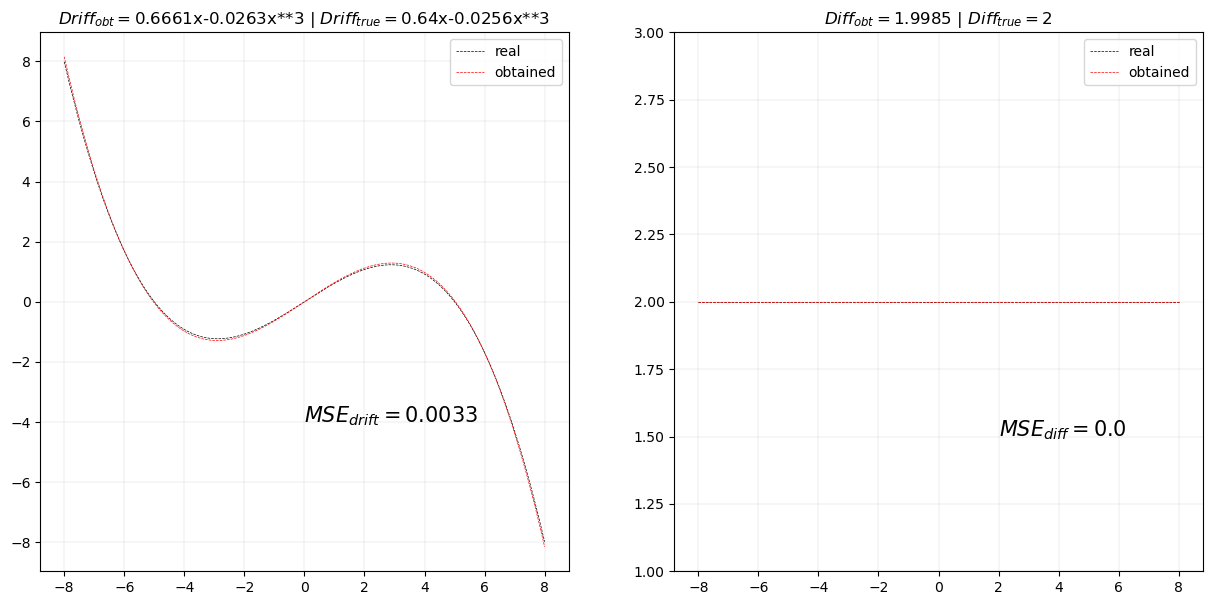

In [213]:
#recreate diffusion and drift equation using obtained coefficients from BISDE
test_pos_dw = np.linspace(-8,8,1000)
difussion_obtained_dw = inferred_dw[1,0]*np.ones(1000)
drift_obtained_dw = drift_dw(inferred_dw[0,1], inferred_dw[0,3], test_pos_dw)
difussion_real_dw = 2*np.ones(1000)
drift_real_dw= drift_dw(C1, C2, test_pos_dw)

#Compute MSE for drift and diffusion
drift_mse_dw = (1/len(drift_real_dw))*(np.sum((drift_real_dw-drift_obtained_dw)**2))
difussion_mse_dw = (1/len(difussion_real_dw))*(np.sum((difussion_real_dw-difussion_obtained_dw)**2))

#plot comparison between drift (real vs obtained)
fig, axis = plt.subplots(1, 2, figsize =(15,7))
axis[0].plot(test_pos_dw, drift_real_dw, label = "real", color ="k", linestyle="dashed", linewidth = 0.5)
axis[0].plot(test_pos_dw, drift_obtained_dw,  label = "obtained", color ="r", linestyle="dashed", linewidth = 0.5)
axis[0].set_title(r"$Driff_{obt}=$"+str(round(inferred_dw[0,1],4))+"x" +str(round(inferred_dw[0,3],4))+"x**3 | " + r"$Driff_{true}=$" +
                         str(round(C1,4))+"x" +str(round(C2,4))+"x**3")
axis[0].grid(color='k', linestyle='-', linewidth=0.05)
axis[0].annotate(r"$MSE_{drift}=$" + str(round(drift_mse_dw,4)), xy = (0 , -4), size = 15)
axis[0].legend()

#plot comparison between difussion (real vs obtained)
axis[1].plot(test_pos_dw, difussion_real_dw, label = "real", color ="k", linestyle="dashed", linewidth = 0.5)
axis[1].plot(test_pos_dw, difussion_obtained_dw,  label = "obtained", color ="r", linestyle="dashed", linewidth = 0.5)
axis[1].set_title(r"$Diff_{obt}=$"+str(round(inferred_dw[1,0],4))+" | " + r"$Diff_{true}=$"+"2")
axis[1].set_ylim(1, 3)
axis[1].grid(color='k', linestyle='-', linewidth=0.05)
axis[1].annotate(r"$MSE_{diff}=$" + str(round(difussion_mse_dw,4)), xy = (2 , 1.5), size = 15)
axis[1].legend()

# B) Harmonic Oscillator

__1) For the first example, we will use the harmonic oscillator potential in 1D. Set initial parameters and compute trayyectories and display.__

In [179]:
#Set initial conditions
number_samples = 50000                                  #total number of iterations
time_step = 0.04                                         #time step for euler differentation
x_stable = [0 ]                                            #initial position
k = 3                                                    #distance from the center to the minimum

#generate trayectories 
trayectories_ha, time_values_ha = generate_trayectories(x_stable, time_step, number_samples, 1, "1D HARMONIC OSCILLATOR", k = k)

__2) Plot the potential and drift used.__

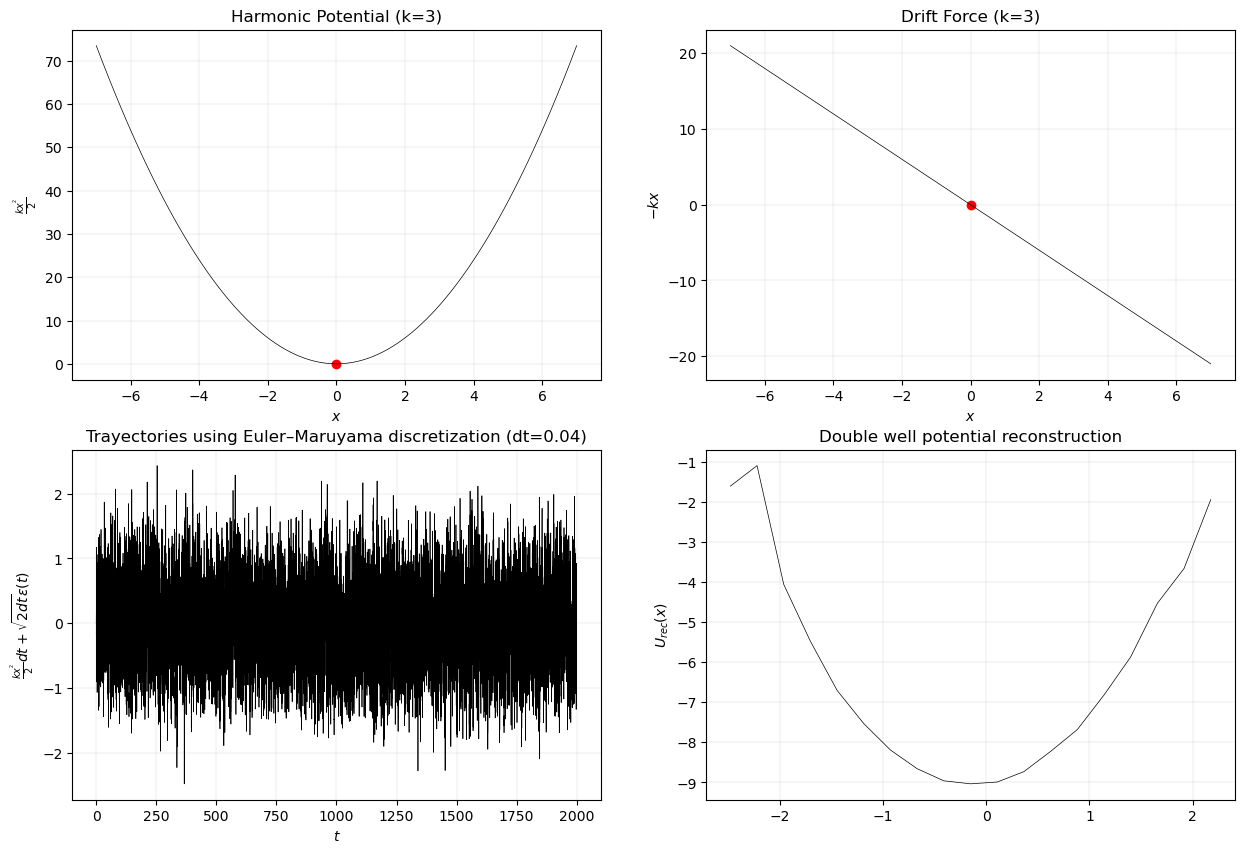

In [180]:
x_pot = np.linspace(-7,7,100)
#store histogram values
hist_values_ha = plt.hist(trayectories_ha, bins="doane")
hist_x_ha, hist_y_ha = hist_values_ha[0], hist_values_ha[1]
plt.close()

#Plot harmonic potential
fig, axis = plt.subplots(2,2, figsize=(15,10))
axis[0,0].plot(x_pot, harmonic_potential(x_pot,k), color = "k", linewidth = 0.5) #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,0].scatter(x_stable, harmonic_potential(x_stable[0],k) , c = "r") 
axis[0,0].set_title("Harmonic Potential (k={})".format(k))
axis[0,0].set_ylabel(r"$\frac{kx^{^{2}}}{2}$")
axis[0,0].set_xlabel(r"$x$")
axis[0,0].grid(color='k', linestyle='-', linewidth=0.05)

#Plot drift
axis[0,1].plot(x_pot, harmonic_force(x_pot,k), color = "k", linewidth = 0.5) #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,1].scatter(x_stable, harmonic_force(x_stable[0],k) , c = "r") 
axis[0,1].set_title("Drift Force (k={})".format(k))
axis[0,1].set_ylabel(r"$-kx$")
axis[0,1].set_xlabel(r"$x$")
axis[0,1].grid(color='k', linestyle='-', linewidth=0.05)

#Plot trayectories
axis[1,0].plot(time_values_ha, trayectories_ha, color ="k", linewidth = 0.5)
axis[1,0].set_title("Trayectories using Euler–Maruyama discretization (dt={})".format(time_step))
axis[1,0].set_ylabel(r"$\frac{kx^{^{2}}}{2}dt + \sqrt{2dt}\varepsilon (t)$")
axis[1,0].set_xlabel(r"$t$")
axis[1,0].grid(color='k', linestyle='-', linewidth=0.05)

#Reconstruct potential
axis[1,1].plot(hist_y_ha[:-1],-np.log(hist_x_ha), color = "k", linewidth = 0.5)
axis[1,1].set_title("Double well potential reconstruction")
axis[1,1].set_ylabel(r"$U_{rec}(x)$")
axis[1,1].grid(color='k', linestyle='-', linewidth=0.05)

__3. Generate library, and infere coefficients for drift and difussion__

In [181]:
#Compute drift and difussion coefficients
inferred_ha = msbl_running([trayectories_ha], time_step, 0.05, 700, 10, 1)

In [182]:
print("The real coefficients for the drift are: -{}*x".format(k))
print("The obtained coefficients for the drift are: {}*x".format(inferred_ha[0,1]))
print("The percent error for drift coefficients are: {}% (x)".format(porcentage_error(k,inferred_ha[0,1]))+"\n")
print("The real coefficient for the diffusion is: {}".format("2"))
print("The obtained coefficient for the diffusion is: {}".format(inferred_ha[1,0]))
print("The percent error for diffusion coefficients is: {}% (c)".format(porcentage_error(2,inferred_ha[1,0])))

The real coefficients for the drift are: -3*x
The obtained coefficients for the drift are: -3.004704798845548*x
The percent error for drift coefficients are: 0.1565810673765972% (x)

The real coefficient for the diffusion is: 2
The obtained coefficient for the diffusion is: 2.0036747163217346
The percent error for diffusion coefficients is: 0.18339884671901469% (c)


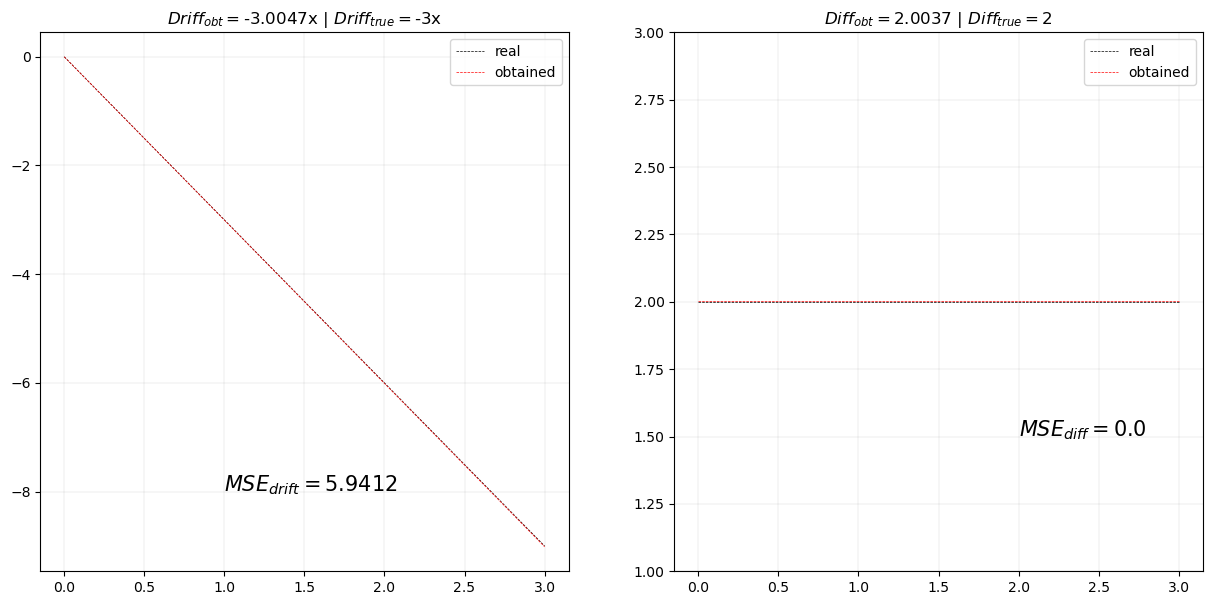

In [183]:
#recreate diffusion and drift equation using obtained coefficients from BISDE
test_pos_ha = np.linspace(0,3,1000)
difussion_obtained_ha = inferred_ha[1,0]*np.ones(1000)
drift_obtained_ha = drift_ho(-inferred_ha[0,1], 1, test_pos_ha)
difussion_real_ha = 2*np.ones(1000)
drift_real_ha= drift_ho(k, 1, test_pos_ha)

#Compute MSE for drift and diffusion
drift_mse_ha = (1/len(drift_real_ha))*(np.sum((drift_real_ha-drift_obtained_ha)**2))
difussion_mse_ha = (1/len(difussion_real_ha))*(np.sum((difussion_real_ha-difussion_obtained_ha)**2))

#plot comparison between drift (real vs obtained)
fig, axis = plt.subplots(1, 2, figsize =(15,7))
axis[0].plot(test_pos_ha, drift_real_ha, label = "real", color ="k", linestyle="dashed", linewidth = 0.5)
axis[0].plot(test_pos_ha, drift_obtained_ha,  label = "obtained", color ="r", linestyle="dashed", linewidth = 0.5)
axis[0].set_title(r"$Driff_{obt}=$"+str(round(inferred_ha[0,1],4))+"x | " + r"$Driff_{true}=$" +
                         str(round(-k,4))+"x")
axis[0].grid(color='k', linestyle='-', linewidth=0.05)
axis[0].annotate(r"$MSE_{drift}=$" + str(round(drift_mse_dw,4)), xy = (1 , -8), size = 15)
axis[0].legend()

#plot comparison between difussion (real vs obtained)
axis[1].plot(test_pos_ha, difussion_real_ha, label = "real", color ="k", linestyle="dashed", linewidth = 0.5)
axis[1].plot(test_pos_ha, difussion_obtained_ha,  label = "obtained", color ="r", linestyle="dashed", linewidth = 0.5)
axis[1].set_title(r"$Diff_{obt}=$"+str(round(inferred_ha[1,0],4))+" | " + r"$Diff_{true}=$"+"2")
axis[1].set_ylim(1, 3)
axis[1].grid(color='k', linestyle='-', linewidth=0.05)
axis[1].annotate(r"$MSE_{diff}=$" + str(round(difussion_mse_ha,4)), xy = (2 , 1.5), size = 15)
axis[1].legend()


# C) 2D Double potential well

__1) Now let's compute a 2D double well potential. Taking the potential, compute the force in y and x. Assume diffusion term is constant.__

In [184]:
#Set initial conditions
number_samples = 50000                         #total number of iterations
time_step = 0.04                                     #time step for euler differentation
xy_init = [1,1]                                      #initial position
c0 = -4                                              #first coefficient of drift in x
c1 = 4                                               #second coefficient of drift in x
c2 = -2                                             # first coefficient of drift in y

#Generate 2d trayectories
trayectories2d_dwx, trayectories2d_dwy, time_values_2ddw = generate_trayectories(xy_init, time_step, number_samples, 1, "2D DOUBLE WELL POTENTIAL")

__2) Generate surface plot for visualizing potential and drift__

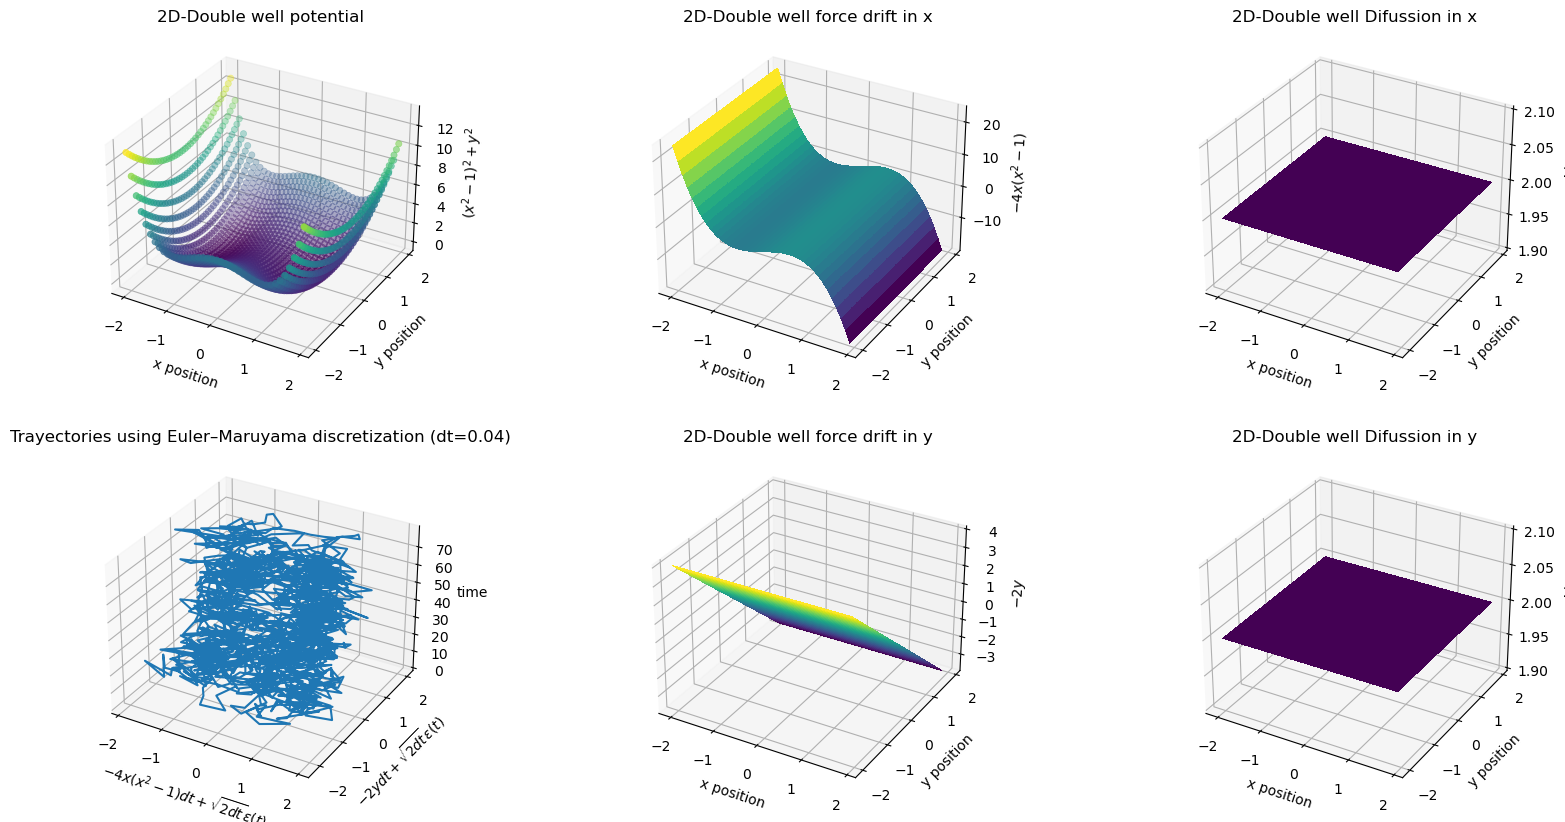

In [185]:
fig, ax = plt.subplots(2,3, subplot_kw={"projection": "3d"}, figsize=(20,10))

# Make data.
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(x, y)
D0 =2*np.ones((len(X), len(Y)))

#Plot potential
ax[0][0].scatter(X,Y, pot_3(X,Y), c =pot_3(X,Y),   cmap='viridis', linewidth=0.5)
ax[0][0].set_title("2D-Double well potential")
ax[0][0].set_xlabel("x position")
ax[0][0].set_ylabel("y position")
ax[0][0].set_zlabel(r"$(x^{2}-1)^{2} + y^{2}$")

#plot drift for x
ax[0][1].plot_surface(X, Y, drift2ddw_x(c0,c1, X, Y), cmap='viridis',linewidth=0, antialiased=False)
ax[0][1].set_title("2D-Double well force drift in x")
ax[0][1].set_xlabel("x position")
ax[0][1].set_ylabel("y position")
ax[0][1].set_zlabel(r"$-4x(x^{2}-1)$")

#plot drift for y
ax[1][1].plot_surface(X, Y, drift2ddw_y(c2, X,Y), cmap='viridis', linewidth=0, antialiased=False)
ax[1][1].set_title("2D-Double well force drift in y")
ax[1][1].set_xlabel("x position")
ax[1][1].set_ylabel("y position")
ax[1][1].set_zlabel(r"$-2y$")


#plot diff for x
ax[0][2].plot_surface(X, Y,D0, cmap='viridis', linewidth=0, antialiased=False)
ax[0][2].set_title("2D-Double well Difussion in x")
ax[0][2].set_xlabel("x position")
ax[0][2].set_ylabel("y position")
ax[0][2].set_zlabel(r"$2$")

#plot diff for y
ax[1][2].plot_surface(X, Y,D0, cmap='viridis', linewidth=0, antialiased=False)
ax[1][2].set_title("2D-Double well Difussion in y")
ax[1][2].set_xlabel("x position")
ax[1][2].set_ylabel("y position")
ax[1][2].set_zlabel(r"$2$")


#plot trayectories
ax[1][0].plot3D(trayectories2d_dwx[:2000], trayectories2d_dwy[:2000], time_values_2ddw[:2000])
ax[1][0].set_title("Trayectories using Euler–Maruyama discretization (dt={})".format(time_step))
ax[1][0].set_xlabel(r"$-4x(x^{2}-1)dt +\sqrt{2dt}\epsilon (t)$")
ax[1][0].set_ylabel(r"$-2ydt +\sqrt{2dt}\epsilon (t)$")
ax[1][0].set_zlabel("time")
plt.show()

__3.1) Show 2D histogram for trayectories__

Text(0.5, 1.0, 'Trayectories in yusing Euler–Maruyama discretization (dt=0.04)')

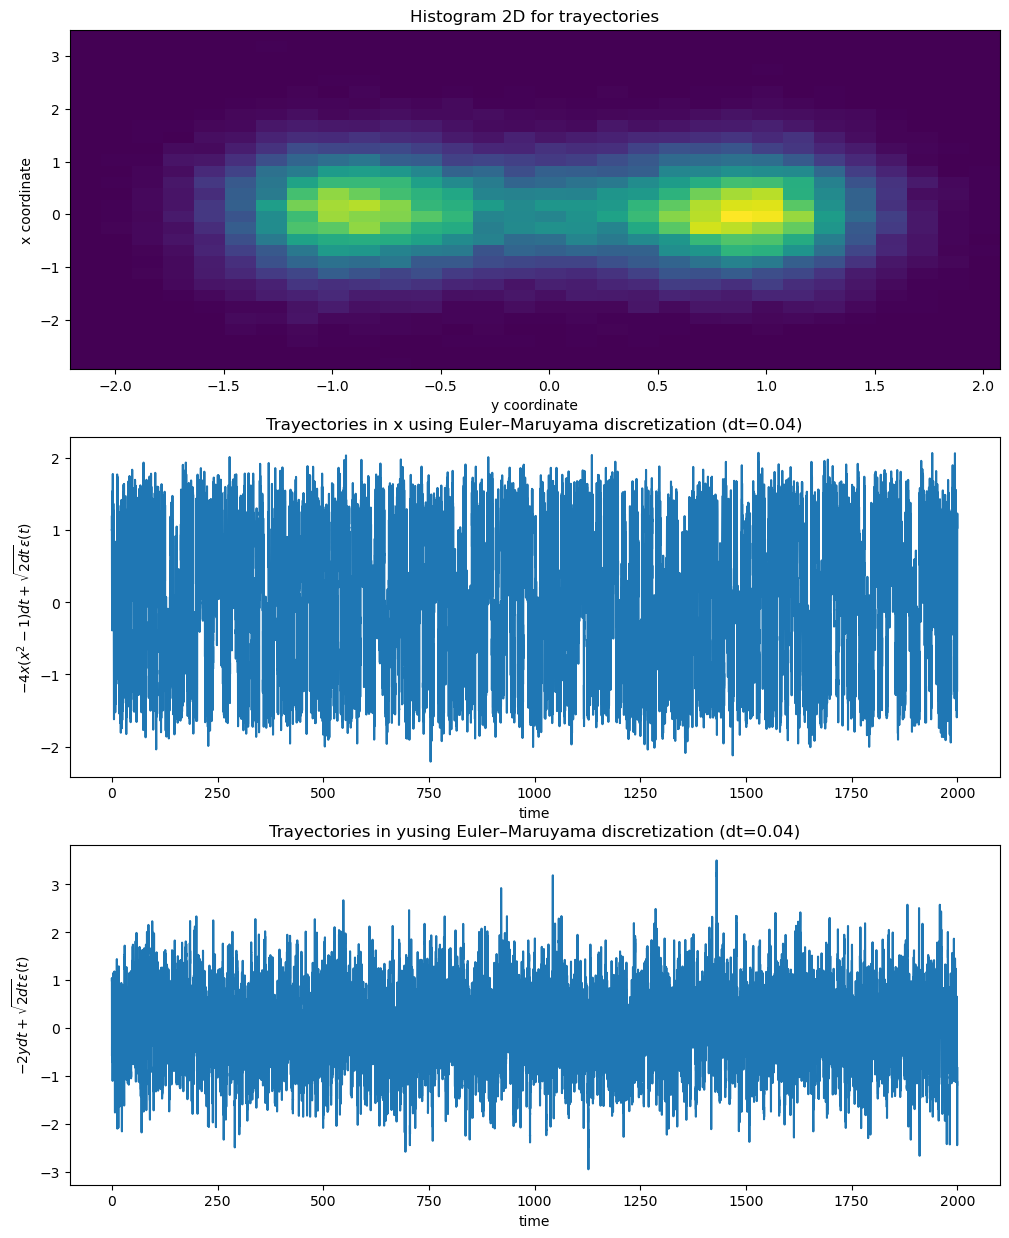

In [186]:
fig, axis = plt.subplots(3, 1, figsize=(12,15))
#plot histogram of trayectories
axis[0].hist2d(trayectories2d_dwx, trayectories2d_dwy, bins=(30,30))
axis[0].set_ylabel("x coordinate")
axis[0].set_xlabel("y coordinate")
axis[0].set_title("Histogram 2D for trayectories")


#plot histogram of trayectories in x
axis[1].plot(time_values_2ddw, trayectories2d_dwx)
axis[1].set_ylabel(r"$-4x(x^{2}-1)dt +\sqrt{2dt}\epsilon (t)$")
axis[1].set_xlabel("time")
axis[1].set_title("Trayectories in x using Euler–Maruyama discretization (dt={})".format(time_step))


#plot histogram of trayectories in x
axis[2].plot(time_values_2ddw, trayectories2d_dwy)
axis[2].set_xlabel("time")
axis[2].set_ylabel(r"$-2ydt +\sqrt{2dt}\epsilon (t)$")
axis[2].set_title("Trayectories in yusing Euler–Maruyama discretization (dt={})".format(time_step))

__3) Compute drift and difussion for x and y independently__

In [187]:
#Compute drift and difussion coefficients
inferred_2ddw = msbl_running([trayectories2d_dwx, trayectories2d_dwy], time_step, 0.05, 1000, 4, 2)

In [188]:
label=["1", "y", "y**2", "y**3", "x", "xy", "xy**2", "xy**3", "x**2", "x**2y",
       "x**2y**2", "x**2y**3", "x**3", "x**3y", "x**3y**2", "x**3y**3"]

print("The real coefficients for the drift in x are: {}*x | {}*x**3".format(4,-4))
print("The obtained coefficients for the drift in x are: {}*x | {}*x**3".format(inferred_2ddw[0,4], inferred_2ddw[0,12]))
print("The percent error for drift coefficients in x are: {}% (x) | {}% (x**3)".format(porcentage_error(4,inferred_2ddw[0,4]), porcentage_error(-4,inferred_2ddw[0,12] ))+"\n")

print("The real coefficients for the drift in y is: {}*y".format(-2))
print("The obtained coefficients for the drift in y is: {}*y".format(inferred_2ddw[2,1]))
print("The percent error for drift coefficients in y are: {}% (y)".format(porcentage_error(-2,inferred_2ddw[2,1]))+"\n")

print("The real coefficient for the diffusion in x is: {}".format("2"))
print("The obtained coefficient for the diffusion in x is: {}".format(inferred_2ddw[1,0]))
print("The percent error for diffusion coefficient in x is: {}% (c)".format(porcentage_error(2,inferred_2ddw[1,0]))+"\n")

print("The real coefficient for the diffusion in y is: {}".format("2"))
print("The obtained coefficient for the diffusion in y is: {}".format(inferred_2ddw[3,0]))
print("The percent error for diffusion coefficient in y is: {}% (c)".format(porcentage_error(2,inferred_2ddw[3,0]))+"\n")

The real coefficients for the drift in x are: 4*x | -4*x**3
The obtained coefficients for the drift in x are: 3.897077928610798*x | -3.9511952703767554*x**3
The percent error for drift coefficients in x are: 2.6410062430004055% (x) | 1.2351890069606941% (x**3)

The real coefficients for the drift in y is: -2*y
The obtained coefficients for the drift in y is: -1.9466491810014999*y
The percent error for drift coefficients in y are: 2.740648881122614% (y)

The real coefficient for the diffusion in x is: 2
The obtained coefficient for the diffusion in x is: 1.9603872553872141
The percent error for diffusion coefficient in x is: 2.0206591582315494% (c)

The real coefficient for the diffusion in y is: 2
The obtained coefficient for the diffusion in y is: 1.979576915299171
The percent error for diffusion coefficient in y is: 1.03168937478454% (c)



__4) Compute obtained drift and diffusion__

In [189]:
#recreate diffusion and drift equation using obtained coefficients from BISDE

#create meshgrid
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(x, y)

#compute real and obtained difussion
difussion_obtained_dwx = 2*np.ones((40,40))
difussion_real_dwx = inferred_2ddw[1,0]*np.ones((40,40))
difussion_obtained_dwy = inferred_2ddw[3,0]*np.ones((40,40))
difussion_real_dwy = 2*np.ones((40,40))

#compute real and obtained dirift
drift_obtained_dwx = drift2ddw_x(inferred_2ddw[0,12], inferred_2ddw[0,4], X, Y)
drift_real_dwx = drift2ddw_x(c0, c1, X, Y)
drift_obtained_dwy = drift2ddw_y(inferred_2ddw[2,1], X, Y)
drift_real_dwy = drift2ddw_y(c2, X, Y)

# mean square error
print("The MSE for the drift in x is: {}".format((1/len(drift_real_dwx)**2)*np.mean(drift_obtained_dwx - drift_real_dwx)))
print("The MSE for the drift in y is: {}".format((1/len(drift_real_dwy)**2)*np.mean(drift_obtained_dwy - drift_real_dwy)))
print("The MSE for the difusion in x is: {}".format((1/len(difussion_real_dwx)**2)*np.mean(difussion_obtained_dwx - difussion_real_dwx)))
print("The MSE for the difussion in y is: {}".format((1/len(difussion_real_dwy)**2)*np.mean(difussion_obtained_dwy - difussion_real_dwy)))

The MSE for the drift in x is: -2.8842764719929915e-06
The MSE for the drift in y is: -1.667213093703071e-06
The MSE for the difusion in x is: 2.475796538299116e-05
The MSE for the difussion in y is: -1.2764427938018185e-05


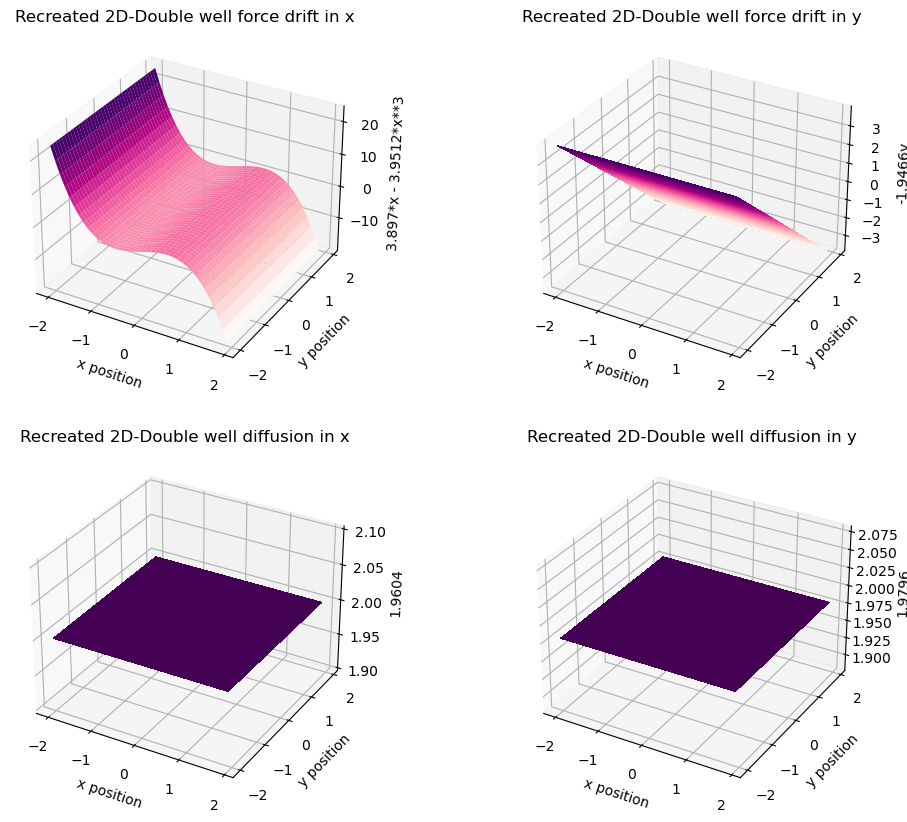

In [190]:
fig, ax = plt.subplots(2,2, subplot_kw={"projection": "3d"}, figsize=(12,10))

# Make data.

#plot obtained drift for x
ax[0][0].plot_surface(X,Y, drift_obtained_dwx ,   cmap='RdPu', linewidth=0.5)
ax[0][0].set_title("Recreated 2D-Double well force drift in x")
ax[0][0].set_xlabel("x position")
ax[0][0].set_ylabel("y position")
ax[0][0].set_zlabel("{}*x - {}*x**3".format(round(inferred_2ddw[0,4],3), round(-inferred_2ddw[0,12], 4)))

#plot obtained drift for y
ax[0][1].plot_surface(X, Y, drift_obtained_dwy, cmap='RdPu',linewidth=0, antialiased=False)
ax[0][1].set_title("Recreated 2D-Double well force drift in y")
ax[0][1].set_xlabel("x position")
ax[0][1].set_ylabel("y position")
ax[0][1].set_zlabel("-{}y".format(round(-inferred_2ddw[2,1],4)))

#plot obtained difussion for x
ax[1][0].plot_surface(X, Y, difussion_obtained_dwx, cmap='viridis', linewidth=0, antialiased=False)
ax[1][0].set_title("Recreated 2D-Double well diffusion in x")
ax[1][0].set_xlabel("x position")
ax[1][0].set_ylabel("y position")
ax[1][0].set_zlabel("{}".format(round(inferred_2ddw[1,0], 4)))

#plot obtained diffusion for y
ax[1][1].plot_surface(X, Y, difussion_obtained_dwy, cmap='viridis', linewidth=0, antialiased=False)
ax[1][1].set_title("Recreated 2D-Double well diffusion in y")
ax[1][1].set_xlabel("x position")
ax[1][1].set_ylabel("y position")
ax[1][1].set_zlabel("{}".format(round(inferred_2ddw[3,0], 4)))

plt.show()

# D) 2D Harmonic Oscillator

__1) Compute trayectories for a 2D Harmonic Oscillator with difussion 2__

In [191]:
#Set initial conditions
number_samples = 50000                               #total number of iterations
time_step = 0.04                                     #time step for euler differentation
xy_init = [1,1]                                      #initial position
k0 = 3                                              #first coefficient
k1 = 5                                               #second coefficient

#Generate 2d trayectories
trayectories2d_hax, trayectories2d_hay, time_values_2ha = generate_trayectories(xy_init, time_step, number_samples, 1, "2D HARMONIC OSCILLATOR", k = k0, m = k1)

__2. Plot trayectories__

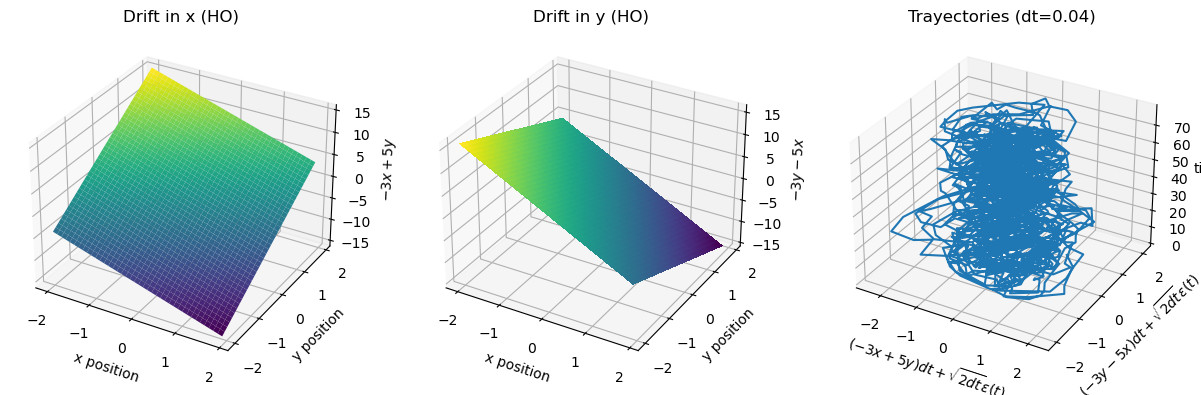

In [192]:
fig, ax = plt.subplots(1,3, subplot_kw={"projection": "3d"}, figsize=(15,10))

# Make data.
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(x, y)

ax[0].plot_surface(X,Y, drift2_x(X,Y,k0,k1),   cmap='viridis', linewidth=0.5)
ax[0].set_title("Drift in x (HO)")
ax[0].set_xlabel("x position")
ax[0].set_ylabel("y position")
ax[0].set_zlabel(r"$-3x+5y$")

#plot drift for x
ax[1].plot_surface(X, Y, drift2_y(X,Y,k0,k1), cmap='viridis',linewidth=0, antialiased=False)
ax[1].set_title("Drift in y (HO)")
ax[1].set_xlabel("x position")
ax[1].set_ylabel("y position")
ax[1].set_zlabel(r"$-3y-5x$")


#plot trayectories
ax[2].plot3D(trayectories2d_hax[:2000], trayectories2d_hay[:2000], time_values_2ha[:2000])
ax[2].set_title("Trayectories (dt={})".format(time_step))
ax[2].set_xlabel(r"$(-3x+5y)dt +\sqrt{2dt}\epsilon (t)$")
ax[2].set_ylabel(r"$(-3y-5x)dt +\sqrt{2dt}\epsilon (t)$")
ax[2].set_zlabel("time")

plt.show()

Text(0.5, 1.0, 'Trayectories in yusing Euler–Maruyama discretization (dt=0.04)')

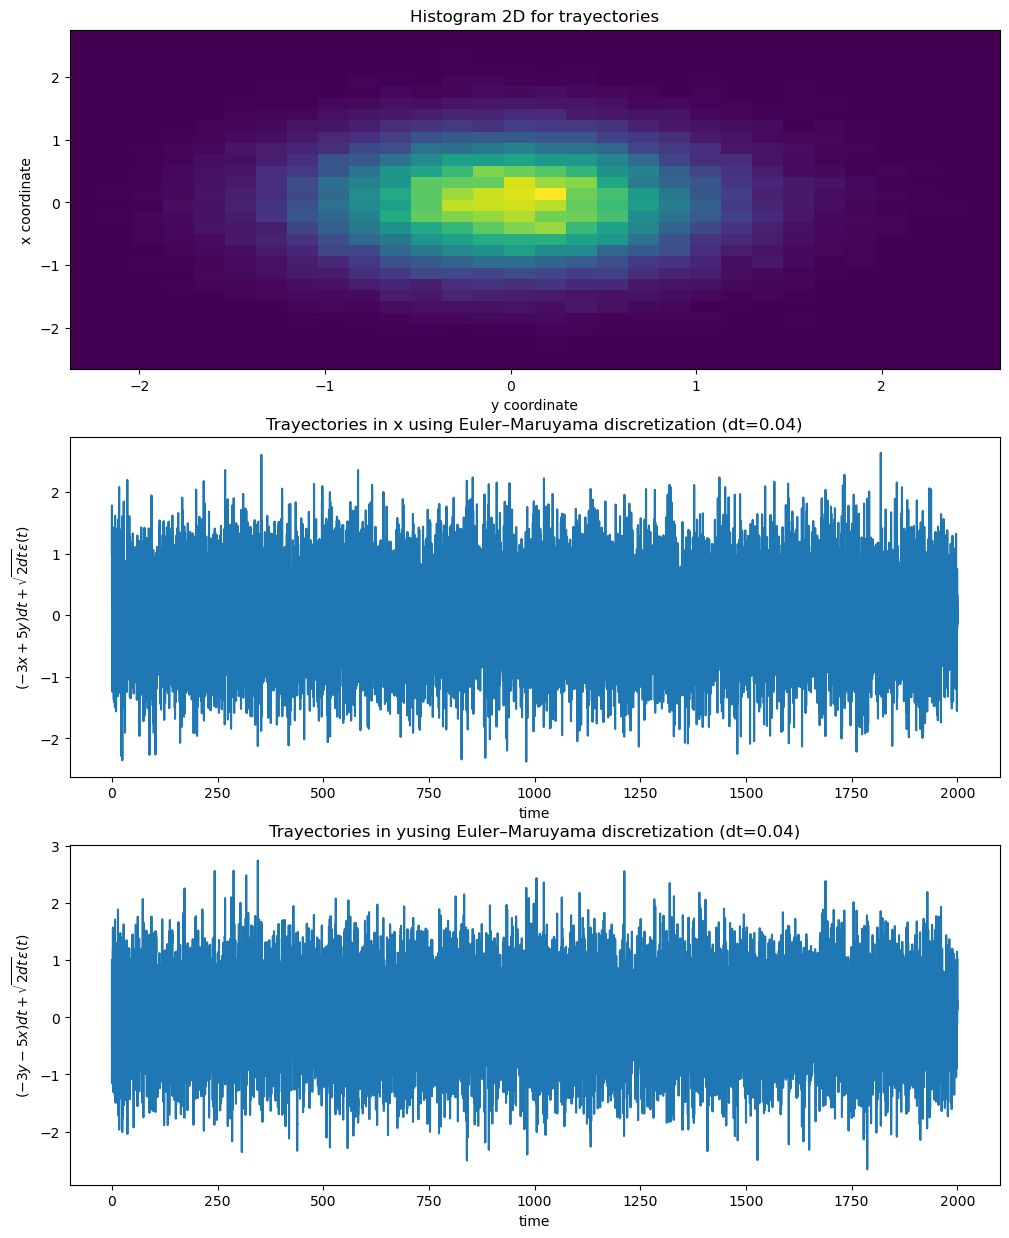

In [193]:
fig, axis = plt.subplots(3, 1, figsize=(12,15))
#plot histogram of trayectories
axis[0].hist2d(trayectories2d_hax, trayectories2d_hay, bins=(30,30))
axis[0].set_ylabel("x coordinate")
axis[0].set_xlabel("y coordinate")
axis[0].set_title("Histogram 2D for trayectories")


#plot histogram of trayectories in x
axis[1].plot(time_values_2ha, trayectories2d_hax)
axis[1].set_ylabel(r"$(-3x+5y)dt +\sqrt{2dt}\epsilon (t)$")
axis[1].set_xlabel("time")
axis[1].set_title("Trayectories in x using Euler–Maruyama discretization (dt={})".format(time_step))

 
#plot histogram of trayectories in y
axis[2].plot(time_values_2ha, trayectories2d_hay)
axis[2].set_xlabel("time")
axis[2].set_ylabel(r"$(-3y-5x)dt +\sqrt{2dt}\epsilon (t)$")
axis[2].set_title("Trayectories in yusing Euler–Maruyama discretization (dt={})".format(time_step))

__3. Compute drift and difussion__

In [194]:
#Compute drift and difussion coefficients
inferred_2dha = msbl_running([trayectories2d_hax, trayectories2d_hay], time_step, 0.05, 1000, 2, 2)

In [195]:
print("The real coefficients for the drift in x are: {}*x | {}*y".format(-k0,k1))
print("The obtained coefficients for the drift in y are: {}*y | {}*x".format(inferred_2dha[0,2], inferred_2dha[0,1]))
print("The percent error for drift coefficients in x are: {}% (x) | {}% (y)".format(porcentage_error(k0,inferred_2dha[0,2]), porcentage_error(k1,inferred_2dha[0,1] ))+"\n")

print("The real coefficients for the drift in y is: {}*y | {}*x".format(-k0, -k1))
print("The obtained coefficients for the drift in y is: {}*y | {}*x".format(inferred_2dha[2,1], inferred_2dha[2,2]))
print("The percent error for drift coefficients in y are: {}% (y) | {}% (x)".format(porcentage_error(-k0,inferred_2dha[2,1]), porcentage_error(k1,inferred_2dha[2,2]) )+"\n")

print("The real coefficient for the diffusion in x is: {}".format("2"))
print("The obtained coefficient for the diffusion in x is: {}".format(inferred_2dha[1,0]))
print("The percent error for diffusion coefficient in x is: {}% (c)".format(porcentage_error(2,inferred_2dha[1,0]))+"\n")

print("The real coefficient for the diffusion in y is: {}".format("2"))
print("The obtained coefficient for the diffusion in y is: {}".format(inferred_2dha[3,0]))
print("The percent error for diffusion coefficient in y is: {}% (c)".format(porcentage_error(2,inferred_2dha[3,0])))

The real coefficients for the drift in x are: -3*x | 5*y
The obtained coefficients for the drift in y are: -2.9865986504549875*y | 4.921205428581529*x
The percent error for drift coefficients in x are: 0.4487161186847414% (x) | 1.601123394704181% (y)

The real coefficients for the drift in y is: -3*y | -5*x
The obtained coefficients for the drift in y is: -2.971293849454165*y | -5.036514674758834*x
The percent error for drift coefficients in y are: 0.9661161770017607% (y) | 0.7249988755484471% (x)

The real coefficient for the diffusion in x is: 2
The obtained coefficient for the diffusion in x is: 2.0127278073731816
The percent error for diffusion coefficient in x is: 0.6323660520094212% (c)

The real coefficient for the diffusion in y is: 2
The obtained coefficient for the diffusion in y is: 1.996104019695724
The percent error for diffusion coefficient in y is: 0.19517922241696814% (c)


__4. Plot obtained functions__

In [196]:
#recreate diffusion and drift equation using obtained coefficients from BISDE

#create meshgrid
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(x, y)

#compute real and obtained difussion
difussion_obtained_hax = 2*np.ones((40,40))
difussion_real_hax = inferred_2dha[1,0]*np.ones((40,40))
difussion_obtained_hay = inferred_2dha[3,0]*np.ones((40,40))
difussion_real_hay = 2*np.ones((40,40))

#compute real and obtained dirift
drift_obtained_hax = drift2_x(X, Y, -inferred_2dha[0,2], inferred_2dha[0,1] )
drift_real_hax = drift2_x(X, Y, k0, k1)
drift_obtained_hay = drift2_y(X, Y, -inferred_2dha[2,1], -inferred_2dha[2,2] )
drift_real_hay = drift2_y(X, Y, k0, k1)

# mean square error
print("The MSE for the drift in x is: {}".format((1/len(drift_real_hax)**2)*np.mean(drift_obtained_hax - drift_real_hax)))
print("The MSE for the drift in y is: {}".format((1/len(drift_real_hay)**2)*np.mean(drift_obtained_hay - drift_real_hay)))
print("The MSE for the difusion in x is: {}".format((1/len(difussion_real_hax)**2)*np.mean(difussion_obtained_hax - difussion_real_hax)))
print("The MSE for the difussion in y is: {}".format((1/len(difussion_real_hay)**2)*np.mean(difussion_obtained_hay - difussion_real_hay)))

The MSE for the drift in x is: 2.043538183545479e-06
The MSE for the drift in y is: 2.4401638165617163e-07
The MSE for the difusion in x is: -7.954879608238486e-06
The MSE for the difussion in y is: -2.4349876901724745e-06


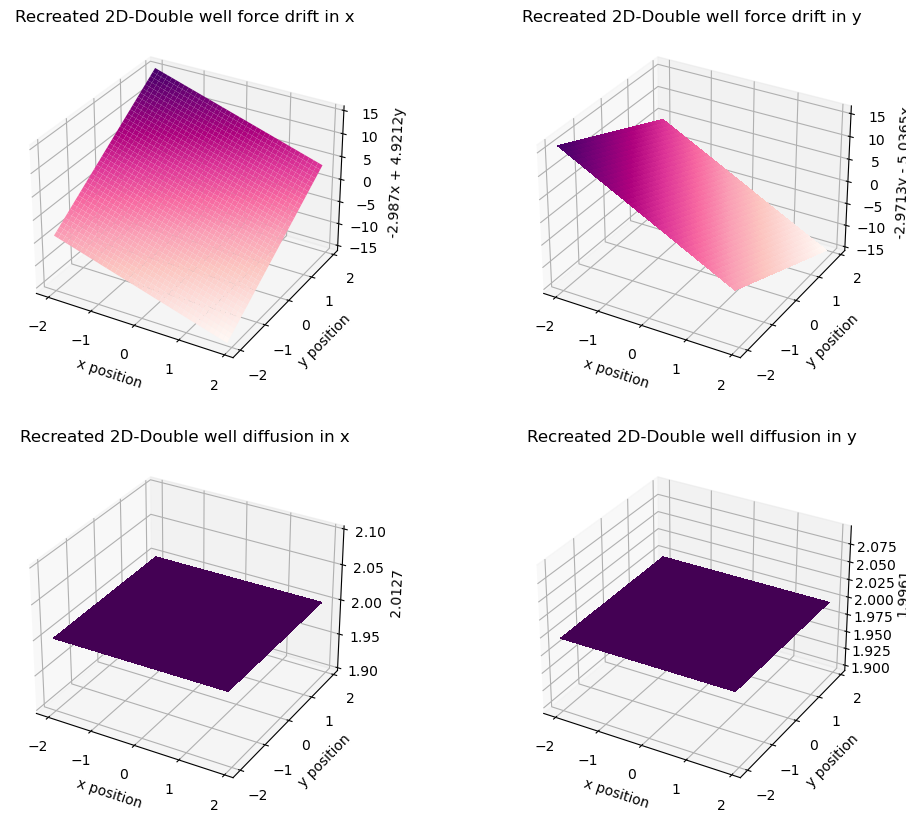

In [197]:
fig, ax = plt.subplots(2,2, subplot_kw={"projection": "3d"}, figsize=(12,10))

#plot obtained drift for x
ax[0][0].plot_surface(X,Y, drift_obtained_hax , cmap='RdPu', linewidth=0.5)
ax[0][0].set_title("Recreated 2D-Double well force drift in x")
ax[0][0].set_xlabel("x position")
ax[0][0].set_ylabel("y position")
ax[0][0].set_zlabel("-{}x + {}y".format(round(-inferred_2dha[0,2],3), round(inferred_2dha[0,1], 4)))

#plot obtained drift for y
ax[0][1].plot_surface(X, Y, drift_obtained_hay, cmap='RdPu',linewidth=0, antialiased=False)
ax[0][1].set_title("Recreated 2D-Double well force drift in y")
ax[0][1].set_xlabel("x position")
ax[0][1].set_ylabel("y position")
ax[0][1].set_zlabel("-{}y - {}x".format(round(-inferred_2dha[2,1],4), round(-inferred_2dha[2,2],4)))

#plot obtained difussion for x
ax[1][0].plot_surface(X, Y, difussion_obtained_hax, cmap='viridis', linewidth=0, antialiased=False)
ax[1][0].set_title("Recreated 2D-Double well diffusion in x")
ax[1][0].set_xlabel("x position")
ax[1][0].set_ylabel("y position")
ax[1][0].set_zlabel("{}".format(round(inferred_2dha[1,0], 4)))

#plot obtained diffusion for y
ax[1][1].plot_surface(X, Y, difussion_obtained_hay, cmap='viridis', linewidth=0, antialiased=False)
ax[1][1].set_title("Recreated 2D-Double well diffusion in y")
ax[1][1].set_xlabel("x position")
ax[1][1].set_ylabel("y position")
ax[1][1].set_zlabel("{}".format(round(inferred_2dha[3,0], 4)))

plt.show()

# E) 3D Attractors

For this section, we can test the BISDE Method in three atractors and try to look for the parameters. In fact, all coefficients of the drift can be estimated but for these cases we just focus on the parameters (showing the real, obtained and error). Diffusion was set to 0.1. We will estimate: <br>
 1. Lorentz Attractor, compute: beta, rho and sigma
 2. Halvorsen Attractor, compute: q
 3. Four-Wing Attractor, compute: a, b, c 

__1) Compute trayectories for each attractor.__

In [156]:
#Global initial conditions
number_samples = 50000                            #total number of iterations
time_step = 0.01                                     #time step for euler differentation

#Set initial conditions for lorentz
xyz_lorentz = [-8,8,27]                               #initial position lorentz
rho = 28                                              #Lorentz coefficient
beta = 2.6                                            #Lorentz coefficient
sigma = 10                                            #Lorentz coefficient

#Set initial conditions for Halvorsen
xyz_halvorsen = [-1.48, -1.51, 2.04]                  #initial position Halvorsen
q = 1.89                                              #Halvorsen coefficient

#Set initial conditions for Four-wing
xyz_fourwing = [1.3, -0.18, 0.01]                  #initial position Halvorsen
a = 0.2                                             #Four-wingcoefficient
b =0.1
c =-0.4
 
#Generate 3d trayectories
trayectories3d_lx, trayectories3d_ly, trayectories3d_lz, time_values_3dl = generate_trayectories(xyz_lorentz, time_step,
                                                                                                  number_samples, 1, "3D LORENTZ ATTRACTOR",
                                                                                                    sigma = 10, rho = 28, beta = 2.6)

                         
trayectories3d_hx, trayectories3d_hy, trayectories3d_hz, time_values_3dh = generate_trayectories(xyz_halvorsen, time_step,
                                                                                                  number_samples, 1, "3D HALVORSEN" ,
                                                                                                  q = q)

trayectories3d_fx, trayectories3d_fy, trayectories3d_fz, time_values_3df = generate_trayectories(xyz_fourwing, time_step,
                                                                                                  number_samples, 1, "3D FOUR-WING" ,
                                                                                                  a = a, b =b, c = c)



__2. Plot trayectories__

Text(0.5, 0, 'z position')

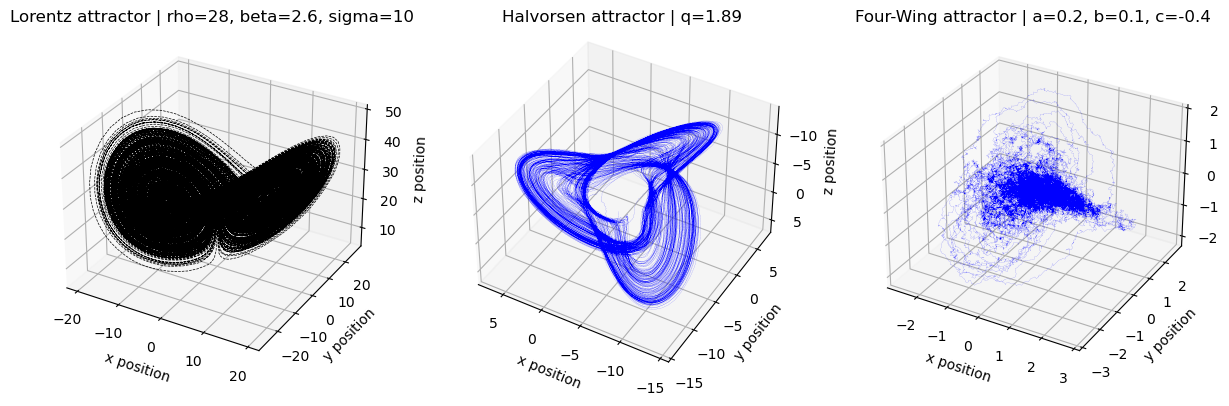

In [172]:
fig, ax = plt.subplots(1,3, subplot_kw={"projection": "3d"}, figsize=(15,7))

# Make data.
ax[0].plot3D(trayectories3d_lx, trayectories3d_ly, trayectories3d_lz, linestyle="dashed", lw = 0.5, color = "black")
ax[0].set_title("Lorentz attractor | rho={}, beta={}, sigma={}".format(rho, beta, sigma))
ax[0].set_xlabel("x position")
ax[0].set_ylabel("y position")
ax[0].set_zlabel("z position")

ax[1].plot3D(trayectories3d_hx, trayectories3d_hy, trayectories3d_hz, lw = 0.1,linestyle="dashed", color = "blue")
ax[1].set_title("Halvorsen attractor | q={}".format(q))
ax[1].set_xlabel("x position")
ax[1].set_ylabel("y position")
ax[1].set_zlabel("z position")
ax[1].view_init(-140, 60)

ax[2].plot3D(trayectories3d_fx, trayectories3d_fy, trayectories3d_fz, lw = 0.1,linestyle="dashed", color = "blue")
ax[2].set_title("Four-Wing attractor | a={}, b={}, c={}".format(a,b,c))
ax[2].set_xlabel("x position")
ax[2].set_ylabel("y position")
ax[2].set_zlabel("z position")


__3.1 Show obtained Lorentz parameters__

In [161]:
inferred_3dl = msbl_running([trayectories3d_lx, trayectories3d_ly, trayectories3d_lz], time_step, 0.05, 700, 2, 3)

In [170]:
print("The real value for rho is: {}".format(rho))
print("The obtained value for rho is: {}".format(inferred_3dl[2,4]))
print("The percent error for rho is: {}%".format(porcentage_error(rho,inferred_3dl[2,4]))+ "\n")

print("The real value for sigma is: {}".format(sigma))
print("The obtained value for sigma is: {}".format(inferred_3dl[0,2]))
print("The percent error for sigma is: {}%".format(porcentage_error(sigma,inferred_3dl[0,2]))+ "\n")

print("The real value for beta is: {}".format(beta))
print("The obtained value for beta is: {}".format(-inferred_3dl[4,1]))
print("The percent error for beta is: {}%".format(porcentage_error(-beta,inferred_3dl[4,1]))+ "\n")

print("The real value for the diffusion (which is the same for all coordinates) is {}, and the obtained is {}".format(0.1, inferred_3dl[1,0]))

The real value for rho is: 28
The obtained value for rho is: 27.984613911335423
The percent error for rho is: 0.05498052863379002%

The real value for sigma is: 10
The obtained value for sigma is: 9.998404879590284
The percent error for sigma is: 0.015953748912210023%

The real value for beta is: 2.6
The obtained value for beta is: 2.5999163403039125
The percent error for beta is: 0.003217784156770634%

The real value for the diffusion (which is the same for all coordinates) is 0.1, and the obtained is 0.10106942384661452


__3.2 Show Four-Wing obtained coefficient__

In [158]:
inferred_3df = msbl_running([trayectories3d_fx, trayectories3d_fy, trayectories3d_fz], time_step, 0.05, 700, 2, 3)

In [160]:
print("The real value for a is: {}".format(a))
print("The obtained value for a is: {}".format(inferred_3df[0,4]))
print("The percent error for rho is: {}%".format(porcentage_error(a, inferred_3df[0,4]))+ "\n")

print("The real value for b is: {}".format(b))
print("The obtained value for b is: {}".format(inferred_3df[2,4]))
print("The percent error for b is: {}%".format(porcentage_error(sigma,inferred_3dl[0,2]))+ "\n")

print("The real value for c is: {}".format(c))
print("The obtained value for c is: {}".format(inferred_3df[2,2]))
print("The percent error for c is: {}%".format(porcentage_error(c ,inferred_3df[2,2]))+ "\n")

print("The real value for the diffusion (which is the same for all coordinates) is {}, and the obtained is {}".format(0.1, inferred_3df[1,0]))

The real value for a is: 0.2
The obtained value for a is: 0.20381827412411158
The percent error for rho is: 1.873371826211468%

The real value for b is: 0.1
The obtained value for b is: 0.09474815545094564
The percent error for b is: 0.035464528183116455%

The real value for c is: -0.4
The obtained value for c is: 0.4133642366572776
The percent error for c is: 3.2330413403320017%

The real value for the diffusion (which is the same for all coordinates) is 0.1, and the obtained is 0.09959937360553732


__3.3 Show Halvorsen obtained coefficients__

In [171]:
inferred_3dh = msbl_running([trayectories3d_hx, trayectories3d_hy, trayectories3d_hz], time_step, 0.05, 700, 3, 3)

In [173]:
print("The real value for q is: {}".format(q))
print("The obtained value for a is: {}".format(-inferred_3dh[0,9]))
print("The percent error for a is: {}%".format(porcentage_error(q,inferred_3dh[0,9]))+ "\n")

The real value for q is: 1.89
The obtained value for a is: 1.8949605206062377
The percent error for a is: 0.26177435109047953%



# SECTION III: TECHNICAL TESTS

Let's test each of the example multiple times changing the coefficients. The goal of this is see how "universal" the code is. The red line is the perfect result, when the obtained value is equal to the real one.

__1D Harmonic potential__

In [227]:
test_ha = bisde_tester_random("1D HARMONIC OSCILLATOR", 100)

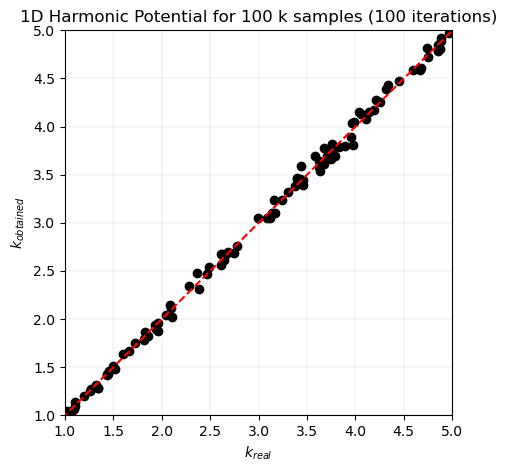

In [291]:
fig, axis = plt.subplots(1,1, figsize=(5,5))
axis.scatter(test_ha[0], -test_ha[1], color = "black")
axis.plot(np.linspace(0,5, 100), np.linspace(0,5, 100), linestyle ="dashed", color ="red")
axis.set_title("1D Harmonic Potential for 100 k samples (100 iterations)")
axis.set_xlabel(r"$k_{real}$")
axis.set_ylabel(r"$k_{obtained}$")
axis.set_xlim(1, 5)
axis.set_ylim(1, 5)
axis.grid(color='k', linestyle='-', linewidth=0.05)


__2D Double Well Potential__

In [276]:
test_dw = bisde_tester_random("1D DOUBLE WELL POTENTIAL", 20)

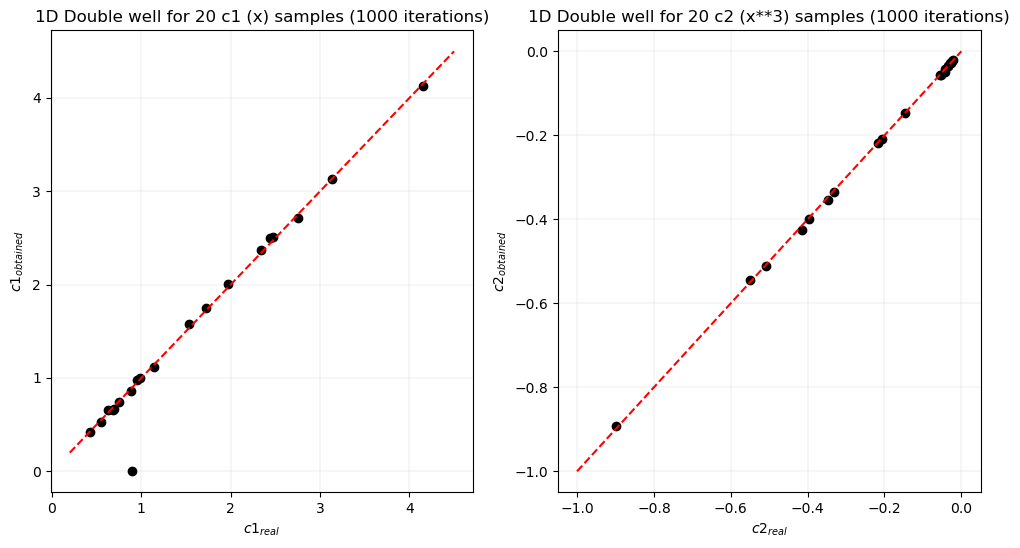

In [290]:
fig, axis = plt.subplots(1,2, figsize=(12,6))
axis[0].scatter(test_dw[0], test_dw[1], color ="black")
axis[0].plot(np.linspace(0.2, 4.5, 100), np.linspace(0.2 ,4.5, 100), linestyle ="dashed", color = "red")
axis[0].set_title("1D Double well for 20 c1 (x) samples (1000 iterations)")
axis[0].set_xlabel(r"$c1_{real}$")
axis[0].set_ylabel(r"$c1_{obtained}$")
axis[0].grid(color='k', linestyle='-', linewidth=0.05)

axis[1].scatter(test_dw[2], test_dw[3], color ="black")
axis[1].plot(np.linspace(-1,0, 100), np.linspace(-1,0, 100), linestyle ="dashed", color = "red")
axis[1].set_title("1D Double well for 20 c2 (x**3) samples (1000 iterations)")
axis[1].set_xlabel(r"$c2_{real}$")
axis[1].set_ylabel(r"$c2_{obtained}$")
axis[1].grid(color='k', linestyle='-', linewidth=0.05)


__2D Double well potential__

In [303]:
test_2dw = bisde_tester_random("2D DOUBLE WELL POTENTIAL", 20)

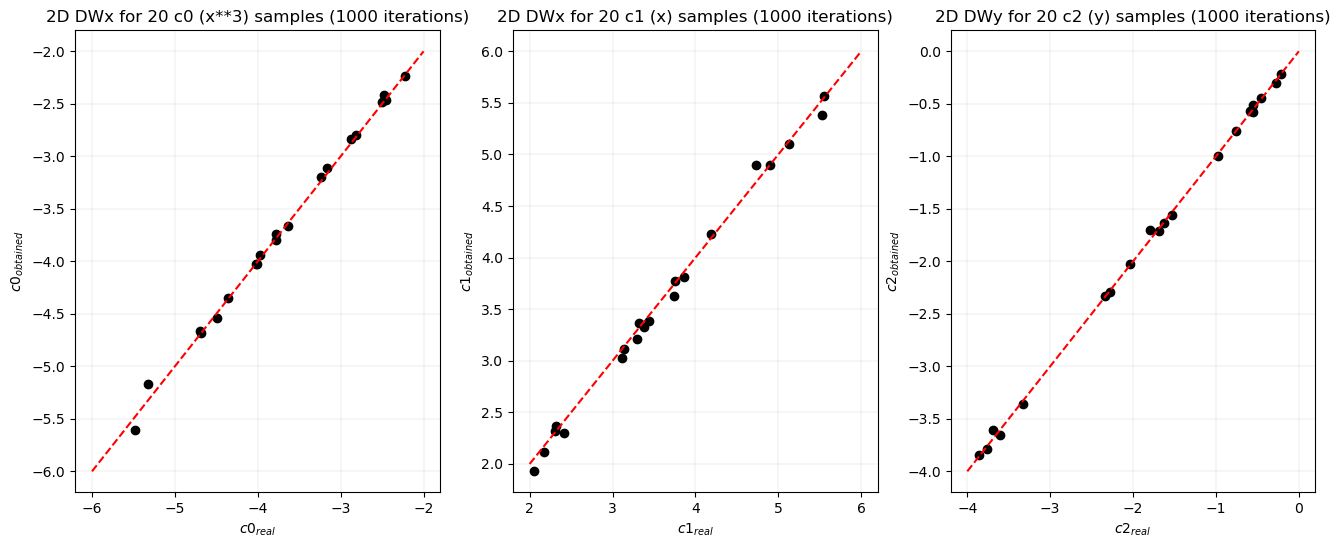

In [305]:
fig, axis = plt.subplots(1,3, figsize=(16,6))
axis[0].scatter(test_2dw[0], test_2dw[1], color ="black")
axis[0].plot(np.linspace(-6, -2, 100), np.linspace(-6, -2, 100), linestyle ="dashed", color = "red")
axis[0].set_title("2D DWx for 20 c0 (x**3) samples (1000 iterations)")
axis[0].set_xlabel(r"$c0_{real}$")
axis[0].set_ylabel(r"$c0_{obtained}$")
axis[0].grid(color='k', linestyle='-', linewidth=0.05)

axis[1].scatter(test_2dw[2], test_2dw[3], color ="black")
axis[1].plot(np.linspace(2, 6, 100), np.linspace(2, 6, 100), linestyle ="dashed", color = "red")
axis[1].set_title("2D DWx for 20 c1 (x) samples (1000 iterations)")
axis[1].set_xlabel(r"$c1_{real}$")
axis[1].set_ylabel(r"$c1_{obtained}$")
axis[1].grid(color='k', linestyle='-', linewidth=0.05)

axis[2].scatter(test_2dw[4], test_2dw[5], color ="black")
axis[2].plot(np.linspace(-4,0, 100), np.linspace(-4,0, 100), linestyle ="dashed", color = "red")
axis[2].set_title("2D DWy for 20 c2 (y) samples (1000 iterations)")
axis[2].set_xlabel(r"$c2_{real}$")
axis[2].set_ylabel(r"$c2_{obtained}$")
axis[2].grid(color='k', linestyle='-', linewidth=0.05)

__2D Harmonic Oscillator__

In [311]:
test_2ha = bisde_tester_random("2D HARMONIC OSCILLATOR", 20)

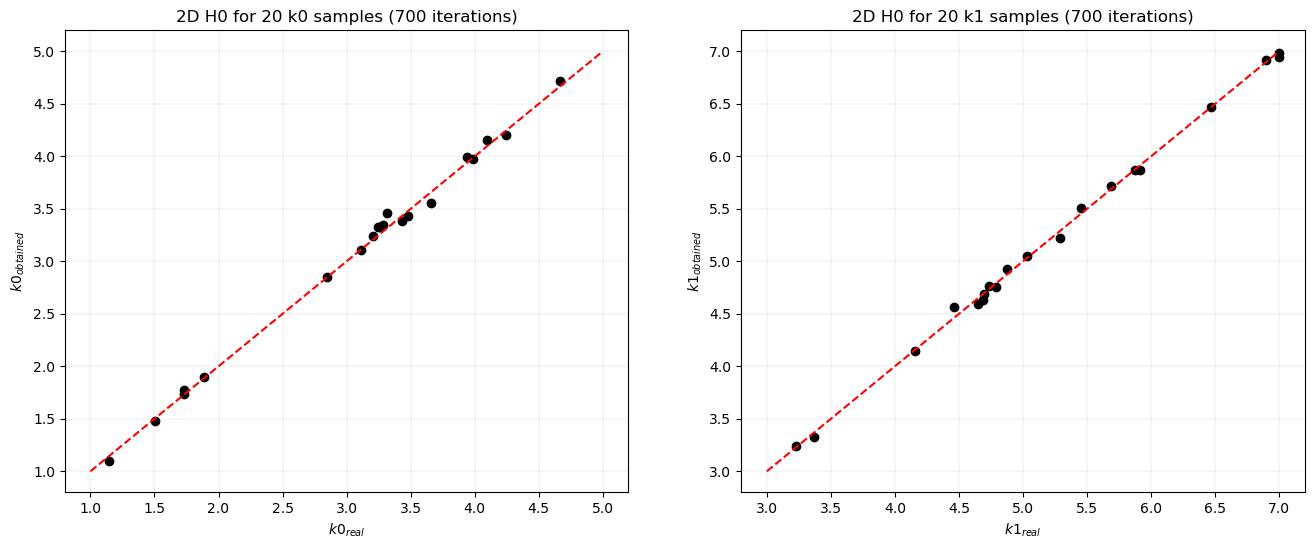

In [312]:
fig, axis = plt.subplots(1,2, figsize=(16,6))
axis[0].scatter(test_2ha[0], -test_2ha[1], color ="black")
axis[0].plot(np.linspace(1, 5, 100), np.linspace(1, 5, 100), linestyle ="dashed", color = "red")
axis[0].set_title("2D H0 for 20 k0 samples (700 iterations)")
axis[0].set_xlabel(r"$k0_{real}$")
axis[0].set_ylabel(r"$k0_{obtained}$")
axis[0].grid(color='k', linestyle='-', linewidth=0.05)

axis[1].scatter(test_2ha[2], test_2ha[3], color ="black")
axis[1].plot(np.linspace(3, 7, 100), np.linspace(3, 7, 100), linestyle ="dashed", color = "red")
axis[1].set_title("2D H0 for 20 k1 samples (700 iterations)")
axis[1].set_xlabel(r"$k1_{real}$")
axis[1].set_ylabel(r"$k1_{obtained}$")
axis[1].grid(color='k', linestyle='-', linewidth=0.05)

# Work cited

1. Wang, Y., Fang, H., Jin, J., Ma, G., He, X., Dai, X., ... & Ding, H. (2022). Data-driven discovery of stochastic differential equations. Engineering, 17, 244-252.
2. Argun, A., Thalheim, T., Bo, S., Cichos, F., & Volpe, G. (2020). Enhanced force-field calibration via machine learning. Applied Physics Reviews, 7(4), 041404.
3. Huang, Y., Mabrouk, Y., Gompper, G., & Sabass, B. (2022). Sparse inference and active learning of stochastic differential equations from data. Scientific Reports, 12(1), 21691.